### Final examples

In [1]:
import torch
import torch.nn.functional
import utils
import text_network
import teacher_network
import vision_network
import time
import random
import numpy as np
import sys

from torch.utils.data import TensorDataset, DataLoader, SequentialSampler

val_img = torch.load("cached_data/val_img")
val_cap = torch.load("cached_data/val_cap")
val_mask = torch.load("cached_data/val_mask")

print("Loaded val data", val_img.size(), val_cap.size(), val_mask.size())

BATCH_SIZE = 128
LOGGER = utils.Logger()

valid_data = TensorDataset(val_img, val_cap, val_mask)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=BATCH_SIZE * 2, num_workers=2)

device = "cuda:0"
text_net = text_network.TextNet(device)
vision_net = vision_network.VisionNet(device)

teacher_net1 = teacher_network.TeacherNet3query()
teacher_net2 = teacher_network.TeacherNet3key()
teacher_net1.to(device)
teacher_net2.to(device)

timeline = "20200130-130202"
teacher_net1.load_state_dict(torch.load("models/enc1-t1-%s" % timeline))
teacher_net2.load_state_dict(torch.load("models/enc2-t2-%s" % timeline,map_location='cuda:0'))
vision_net.model.load_state_dict(torch.load("models/enc1-%s" % timeline))
text_net.model.load_state_dict(torch.load("models/enc2-%s" % timeline,map_location='cuda:0'))

text_net.model.eval()
vision_net.model.eval()
teacher_net1.eval()
teacher_net2.eval()

print("Start to evaluate")
img_vecs = []
txt_vecs = []
with torch.no_grad():
    for step, batch in enumerate(valid_dataloader):
        img, cap, mask = tuple(t.to(device) for t in batch)
        img_vec = teacher_net1.forward(vision_net.forward(img))
        txt_vec = teacher_net2.forward(text_net.forward(cap, mask))

        img_vecs.append(img_vec)
        txt_vecs.append(txt_vec)

img_vecs = torch.cat(img_vecs, dim=0)
txt_vecs = torch.cat(txt_vecs, dim=0)
print("done")

Loaded val data torch.Size([5000, 3, 224, 224]) torch.Size([5000, 43]) torch.Size([5000, 43])
Start to evaluate
done


#### Consider pairs of the text-image correspondences

In [2]:
correct = 0
correctn = 0

count = 0
results = []
dict_pred = {}
for du1 in range(30):
    preds = []
    count += 1
    for du2 in range(img_vecs.size(0)):
        preds.append(torch.matmul(img_vecs[du1].view(1, 100), txt_vecs[du2].view(100, 1)).item())
    if np.argmax(preds) == du1:
        correct += 1
    dict_pred[du1] = np.argsort(preds)
    for i in range(1, img_vecs.size(0)):
        if du1 in dict_pred[du1][-i:]:
            results.append(i)
            break
for du78, du79 in enumerate(results):
    print(du78, du79)

0 696
1 157
2 88
3 1
4 71
5 99
6 37
7 20
8 45
9 294
10 31
11 51
12 34
13 179
14 14
15 12
16 52
17 81
18 2
19 28
20 129
21 107
22 3
23 34
24 4
25 39
26 27
27 4
28 14
29 6


In [3]:
from transformers import DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

 a cheesy pizza sitting on top of a table. 
 two slices of vegetarian pizza wait to be eaten 
 there is a freshly made pizza out of the oven 
 a large pizza sitting on top of a cutting board. 
 a large pepperoni and mushroom pizza being cut 
 a large pizza with topping served on a wooden board 
 a white plate topped with sliced of pizza. 
 two different pizzas that just came out of an oven. 
 a very large pizza covered in cheese and toppings. 
 a vegetarian pizza is half eaten on a pizza holder. 
 a pizza sitting on top of a white plate covered in cheese and sauce. 
 a large sliced pizza on a plate on a table. 
 a fresh homemade pizza sitting on the stove. 
 two pizzas sitting on pizza pans on a oven. 
 a close up of a pizza on a plate with knives and forks 
 a meal on a table which includes pizza in a box and a bottle of beer along with a beer mug 
 meatball pizza on a pan next to a glass of beer. 
 a large pizza placed on top of table next to a wineglass 
 a metal plate holding a piz

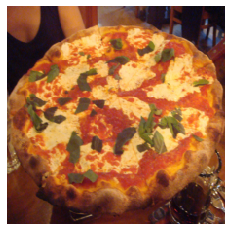

In [7]:
import matplotlib.pyplot as plt
import torchvision.transforms as TF
import imageio


idx = 7
for i in dict_pred[idx][-results[idx]:]:
    _, cap, _ = valid_data[i]
    cap = tokenizer.decode(cap[cap>0].cpu().numpy())
    print(cap[5:-5])

img, cap, mask = valid_data[idx]
std=[0.229, 0.224, 0.225]
mean=[0.485, 0.456, 0.406]
img = img.clone()
img[0, :, :] = img[0, :, :] * std[0] + mean[0]
img[1, :, :] = img[1, :, :] * std[1] + mean[1]
img[2, :, :] = img[2, :, :] * std[2] + mean[2]
plt.axis("off")
f1 = TF.ToPILImage()
img = f1(img)
plt.imshow(img)
plt.show()
imageio.imwrite("test.png", img)

#### Consider pairs of the image-text correspondences

In [8]:
correct = 0
correctn = 0

count = 0
results = []
dict_pred = {}
for du1 in range(30):
    preds = []
    count += 1
    for du2 in range(img_vecs.size(0)):
        preds.append(torch.matmul(txt_vecs[du1].view(1, 100), img_vecs[du2].view(100, 1)).item())
    if np.argmax(preds) == du1:
        correct += 1
    dict_pred[du1] = np.argsort(preds)
    for i in range(1, txt_vecs.size(0)):
        if du1 in dict_pred[du1][-i:]:
            results.append(i)
            break
for du78, du79 in enumerate(results):
    print(du78, du79)

0 640
1 139
2 21
3 1
4 34
5 159
6 32
7 74
8 22
9 592
10 19
11 18
12 14
13 159
14 22
15 12
16 267
17 53
18 6
19 110
20 19
21 192
22 1
23 98
24 1
25 107
26 124
27 2
28 1
29 53


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


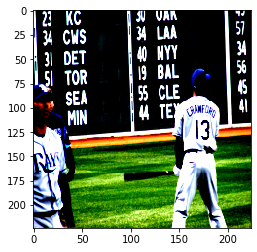

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


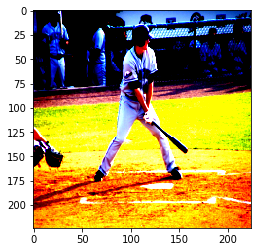

[CLS] men on a baseball field with the batter holding the bat sideways. [SEP]


In [6]:
import matplotlib.pyplot as plt
import torchvision.transforms as TF
import imageio
from transformers import DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

idx = 27
for i in dict_pred[idx][-results[idx]:]:
    img, _, _ = valid_data[i]
    plt.imshow((img.permute(1, 2, 0)))
    plt.show()

_, cap, _ = valid_data[idx]
cap = tokenizer.decode(cap[cap>0].cpu().numpy())
print(cap)